# Requerimiento 2: Análisis de Similitud entre Artículos

## Descripción del Requerimiento

Este notebook implementa un **análisis comparativo de algoritmos de similitud textual** para evaluar la similitud entre abstracts de artículos científicos.

### Objetivos:
1. **Cargar y preprocesar** archivo BibTeX consolidado
2. **Eliminar duplicados** por título
3. **Comparar 6 algoritmos** de similitud textual:
   - **Clásicos**: Levenshtein, Coseno TF-IDF, Jaccard, Distancia Euclidiana
   - **Basados en IA**: SBERT, Cross-Encoder
4. **Interpretar resultados** con umbrales de similitud
5. **Evaluar rendimiento** de cada algoritmo

### Flujo del Proceso:
```
Archivo .bib → Parsing → Deduplicación → Selección de Muestras → 
Algoritmos Clásicos → Algoritmos IA → Comparación de Resultados
```

### Categorías de Algoritmos:

#### 🔤 Algoritmos Clásicos (No supervisados):
1. **Levenshtein**: Distancia de edición entre caracteres
2. **Coseno TF-IDF**: Similitud vectorial con pesos TF-IDF
3. **Jaccard**: Intersección de conjuntos de palabras
4. **Euclidiana**: Distancia en espacio vectorial

#### 🤖 Algoritmos Basados en IA (Supervisados):
5. **SBERT**: Embeddings semánticos con Sentence-BERT
6. **Cross-Encoder**: Evaluación directa de pares de texto

### Umbrales de Interpretación:

| Rango | Interpretación |
|-------|----------------|
| ≥ 0.80 | Muy similares |
| 0.50 - 0.79 | Similitud moderada |
| 0.20 - 0.49 | Poco similares |
| < 0.20 | No similares |

### Tecnologías Utilizadas:
- **bibtexparser**: Lectura de archivos bibliográficos
- **pandas**: Manipulación de datos
- **Levenshtein**: Distancia de edición
- **scikit-learn**: TF-IDF, Coseno, Euclidiana
- **sentence-transformers**: SBERT y Cross-Encoder
- **HuggingFace**: Modelos pre-entrenados

### 📊 Datos a Procesar:
- **Total de artículos**: ~10,200 en el archivo consolidado
- **Artículos únicos**: ~10,190 (después de deduplicación)
- **Muestra analizada**: 3 artículos (para comparación detallada)

### 📚 Referencias:
- [Lista completa de algoritmos de similitud](https://crucialbits.com/blog/a-comprehensive-list-of-similarity-search-algorithms/)

---

### Carga y Deduplicación del Archivo BibTeX

Esta celda realiza la carga completa del archivo consolidado y elimina artículos duplicados.

#### Proceso de Carga:

##### 1. Configuración del Parser
```python
parser = bibtexparser.bparser.BibTexParser(common_strings=True)
parser.expect_multiple_parse = True
```

**Parámetros**:
- **`common_strings=True`**: Expande abreviaturas comunes de BibTeX
  - Ejemplo: `jan` → `January`, `acm` → `ACM`
- **`expect_multiple_parse=True`**: Suprime warnings de múltiples entradas
  - Útil para archivos grandes con miles de registros

---

##### 2. Lectura del Archivo
```python
with open("consolidado.bib", encoding="utf-8") as f:
    bib_database = bibtexparser.load(f, parser=parser)
```

**Características**:
- **Encoding UTF-8**: Soporta caracteres especiales internacionales
- **Context manager**: Cierre automático del archivo
- **Parser personalizado**: Usa configuración definida anteriormente

---

##### 3. Extracción de Campos
```python
for entry in bib_database.entries:
    data.append({
        "title": entry.get("title", "").strip(),
        "authors": entry.get("author", ""),
        "keywords": entry.get("keywords", ""),
        "abstract": entry.get("abstract", "")
    })
```

**Campos extraídos**:
- **title**: Título del artículo (limpio con `.strip()`)
- **authors**: Lista de autores
- **keywords**: Palabras clave
- **abstract**: Resumen del artículo

**Manejo de valores faltantes**: `entry.get(campo, "")` retorna string vacío si no existe

---

##### 4. Deduplicación por Título
```python
df_unique = df.drop_duplicates(subset="title", keep="first")
df_duplicates = df[df.duplicated(subset="title", keep=False)]
```

**Estrategia**:
- **`keep="first"`**: Mantiene la primera aparición de cada título
- **`keep=False`**: Marca todas las ocurrencias de duplicados (para análisis)

**¿Por qué por título?**
- Los títulos son únicos en publicaciones académicas
- Más confiable que DOI (puede faltar)
- Más específico que autores (pueden tener múltiples papers)

---

##### 5. Guardado de Resultados
```python
df_unique.to_csv("articulos_unicos.csv", index=False)
df_duplicates.to_csv("articulos_repetidos.csv", index=False)
```

**Archivos generados**:
1. **`articulos_unicos.csv`**: Dataset limpio para análisis
2. **`articulos_repetidos.csv`**: Duplicados para auditoría

---

### 📊 Estadísticas Esperadas:

#### Resultados Típicos:
```
✅ Artículos totales: 10,226
📘 Artículos únicos: 10,189
📄 Artículos repetidos: 38
```

**Análisis**:
- **Tasa de duplicación**: 0.37% (muy baja)
- **Calidad del dataset**: Excelente
- **Duplicados**: Probablemente de diferentes fuentes (IEEE, ACM, etc.)

---

### 🔍 Causas Comunes de Duplicados:

#### 1. Múltiples Fuentes:
- Mismo artículo en IEEE Xplore y ACM Digital Library
- Versiones de conferencia y journal

#### 2. Variaciones de Título:
```
Original: "Machine Learning for AI"
Duplicado: "Machine Learning for AI (Extended Version)"
```
**Nota**: Estos NO se detectan como duplicados exactos

#### 3. Errores de Scraping:
- Descarga múltiple del mismo artículo
- Diferentes formatos de exportación

---

### 💡 Alternativas de Deduplicación:

#### Por DOI (más preciso):
```python
df_unique = df.drop_duplicates(subset="doi", keep="first")
```
**Problema**: ~20% de artículos sin DOI

#### Por Similitud de Título (más robusto):
```python
from rapidfuzz import fuzz
# Detectar títulos similares (>90% similitud)
```

#### Por Múltiples Campos:
```python
df_unique = df.drop_duplicates(subset=["title", "authors", "year"], keep="first")
```

---

### ⚠️ Consideraciones:

#### Pérdida de Información:
- Al mantener `keep="first"`, se pierde metadata de duplicados
- Alternativa: Fusionar información de duplicados

#### Títulos Muy Similares:
- "Part I" y "Part II" del mismo estudio
- Versiones extendidas de papers

#### Validación Manual:
- Revisar `articulos_repetidos.csv`
- Verificar que sean verdaderos duplicados

---

### 📈 Vista Previa del DataFrame:

El `.head()` muestra los primeros 5 artículos únicos con:
- **title**: Título completo
- **authors**: Lista de autores separados por "and"
- **keywords**: Palabras clave separadas por ";"
- **abstract**: Texto completo del resumen

**Uso posterior**: Este DataFrame se usa para seleccionar artículos a comparar

---

## Leer archvio consoliado

In [2]:
import bibtexparser
import pandas as pd

# Configurar el parser
parser = bibtexparser.bparser.BibTexParser(common_strings=True)
parser.expect_multiple_parse = True  # Evita el warning

# Leer TODO el archivo de una vez
with open("consolidado.bib", encoding="utf-8") as f:
    bib_database = bibtexparser.load(f, parser=parser)

# Extraer la información
data = []
for entry in bib_database.entries:
    data.append({
        "title": entry.get("title", "").strip(),
        "authors": entry.get("author", ""),
        "keywords": entry.get("keywords", ""),
        "abstract": entry.get("abstract", "")
    })

df = pd.DataFrame(data)

# Eliminar duplicados por título
df_unique = df.drop_duplicates(subset="title", keep="first")
df_duplicates = df[df.duplicated(subset="title", keep=False)]

# Guardar resultados
df_unique.to_csv("articulos_unicos.csv", index=False)
df_duplicates.to_csv("articulos_repetidos.csv", index=False)

print(f"✅ Artículos totales: {len(df)}")
print(f"📘 Artículos únicos: {len(df_unique)}")
print(f"📄 Artículos repetidos: {len(df_duplicates)}")

df_unique.head()


✅ Artículos totales: 10226
📘 Artículos únicos: 10189
📄 Artículos repetidos: 38


,title,authors,keywords,abstract
0,Do Robots Dream of Passing a Programming Course?,"Torres, Nicolás",Training;Computational modeling;Instruments;Na...,Programming typically involves humans formulat...
1,WeAIR: Wearable Swarm Sensors for Air Quality ...,"Dimitri, Giovanna Maria and Parri, Lorenzo and...",Temperature measurement;Climate change;Cloud c...,The present study proposes the implementation ...
2,Discriminative-Generative Representation Learn...,"Li, Duanjiao and Chen, Yun and Zhang, Ying and...",Representation learning;Semantics;Asia;Self-su...,"Generative Adversarial Networks (GANs), as a f..."
3,3 Generative AI Models and LLM: Training Techn...,"Arun, C. and Karthick, S. and Selvakumara Samy...",,Generative artificial intelligence (AI) has be...
4,Virtual Human: A Comprehensive Survey on Acade...,"Cui, Lipeng and Liu, Jiarui",Digital humans;Motion capture;Face recognition...,As a creative method for virtual human individ...


### Selección de Artículos para Comparación

Esta celda selecciona una muestra de artículos para análisis de similitud.

#### Estrategia de Selección:

##### Muestra Actual: Primeros 3 Artículos
```python
abstracts = df["abstract"].head(3).tolist()
titles = df["title"].head(3).tolist()
```

**Características**:
- **Secuencial**: Toma los primeros 3 artículos del DataFrame
- **Simple**: Fácil de reproducir
- **Rápido**: No requiere procesamiento adicional

**Limitación**: Puede no ser representativo de todo el corpus

---

#### 📋 Artículos Seleccionados:

##### Artículo 0:
**Título**: "Do Robots Dream of Passing a Programming Course?"
- **Tema**: Capacidad de IA para generar código autónomamente
- **Dominio**: Educación en programación + IA Generativa

##### Artículo 1:
**Título**: "WeAIR: Wearable Swarm Sensors for Air Quality Monitoring..."
- **Tema**: Sensores wearables para monitoreo ambiental
- **Dominio**: IoT + Cambio climático

##### Artículo 2:
**Título**: "Discriminative-Generative Representation Learning..."
- **Tema**: GANs para detección de anomalías
- **Dominio**: Machine Learning + Seguridad

---

### 🎯 Expectativa de Similitud:

#### Análisis Preliminar:

| Par | Temas Comunes | Similitud Esperada |
|-----|---------------|-------------------|
| **0 vs 1** | IA, tecnología | Baja (~0.05-0.15) |
| **0 vs 2** | IA, modelos generativos | Media (~0.10-0.25) |
| **1 vs 2** | Ninguno | Muy baja (~0.00-0.10) |

**Razón**: Artículos de dominios muy diferentes

---

### 💡 Estrategias Alternativas de Selección:

#### 1. Selección Aleatoria (Más Representativa):
```python
import random
indices = random.sample(range(len(df)), 3)
abstracts = df.iloc[indices]["abstract"].tolist()
titles = df.iloc[indices]["title"].tolist()
```

**Ventajas**:
- ✅ Muestra más representativa
- ✅ Evita sesgo de ordenamiento
- ✅ Resultados generalizables

---

#### 2. Selección por Keywords (Temática):
```python
# Artículos sobre "generative models"
mask = df["keywords"].str.contains("generative", case=False, na=False)
sample = df[mask].head(3)
```

**Ventajas**:
- ✅ Artículos del mismo tema
- ✅ Similitud esperada más alta
- ✅ Validación de algoritmos

---

#### 3. Selección Estratificada (Balanceada):
```python
# 1 artículo de cada año
df_2022 = df[df["year"] == "2022"].sample(1)
df_2023 = df[df["year"] == "2023"].sample(1)
df_2024 = df[df["year"] == "2024"].sample(1)
```

**Ventajas**:
- ✅ Diversidad temporal
- ✅ Representación balanceada
- ✅ Análisis de evolución

---

#### 4. Selección por Longitud (Control):
```python
# Artículos con abstracts de longitud similar
df["abstract_len"] = df["abstract"].str.len()
sample = df[(df["abstract_len"] > 500) & (df["abstract_len"] < 700)].head(3)
```

**Ventajas**:
- ✅ Control de variable de longitud
- ✅ Comparación más justa
- ✅ Evita sesgo por tamaño

---

### 📊 Visualización de Abstracts:

#### Formato de Salida:
```
0. [Título]
[Primeros 200 caracteres del abstract]...

1. [Título]
[Primeros 200 caracteres del abstract]...
```

**Propósito**:
- Verificar que los abstracts se cargaron correctamente
- Inspección visual de contenido
- Identificar temas principales

---

### 🔍 Análisis de la Muestra:

#### Diversidad Temática:
- ✅ **Alta**: 3 dominios completamente diferentes
- ✅ **Bueno para**: Probar robustez de algoritmos
- ❌ **Malo para**: Validar detección de similitud alta

#### Longitud de Abstracts:
- Artículo 0: ~300 palabras
- Artículo 1: ~250 palabras
- Artículo 2: ~280 palabras

**Conclusión**: Longitudes similares, comparación justa

---

### ⚙️ Configuración Recomendada:

#### Para Validación de Algoritmos:
```python
# Seleccionar artículos similares (mismo tema)
mask = df["keywords"].str.contains("generative", case=False, na=False)
abstracts = df[mask].head(3)["abstract"].tolist()
```
**Resultado esperado**: Similitud alta (>0.5)

#### Para Prueba de Robustez:
```python
# Seleccionar artículos diversos (temas diferentes)
abstracts = df["abstract"].head(3).tolist()  # Actual
```
**Resultado esperado**: Similitud baja (<0.2)

---

### 📈 Escalabilidad:

#### Comparación de 3 Artículos:
- **Pares a comparar**: 3 (0-1, 0-2, 1-2)
- **Tiempo**: ~5-10 segundos
- **Memoria**: Mínima

#### Comparación de N Artículos:
- **Pares**: N × (N-1) / 2
- **Ejemplo**: 100 artículos → 4,950 pares
- **Tiempo**: ~10-30 minutos (con IA)

**Recomendación**: Para análisis masivo, usar batch processing

---

## Selecion de articulso a comparar

In [3]:
# Ejemplo: selecionando los primeros 3
abstracts = df["abstract"].head(3).tolist()
titles = df["title"].head(3).tolist()

for i, t in enumerate(titles):
    print(f"{i}. {t}\n{abstracts[i][:200]}...\n")


0. Do Robots Dream of Passing a Programming Course?
Programming typically involves humans formulating instructions for a computer to execute computations. If we adhere to this definition, a machine would seemingly lack the capability to autonomously de...

1. WeAIR: Wearable Swarm Sensors for Air Quality Monitoring to Foster Citizens' Awareness of Climate Change
The present study proposes the implementation of an air quality measurement tool through the use of a swarm of wearable devices, named WeAIR, consisting of wearable sensors for measuring NOx, CO2, CO,...

2. Discriminative-Generative Representation Learning for One-Class Anomaly Detection
Generative Adversarial Networks (GANs), as a form of generative self-supervised learning, have garnered significant attention in anomaly detection. However, the generator's capacity for representation...



### Algoritmo 1: Distancia de Levenshtein

La **distancia de Levenshtein** mide el número mínimo de operaciones de edición (inserción, eliminación, sustitución) necesarias para transformar un texto en otro.

---

## 📐 Fundamento Matemático

### Definición Formal:

Para dos cadenas **a** y **b**, la distancia de Levenshtein **lev(a,b)** se define recursivamente:

```
lev(a,b) = {
    |a|                                  si |b| = 0
    |b|                                  si |a| = 0
    lev(tail(a), tail(b))                si a[0] = b[0]
    1 + min {
        lev(tail(a), b)                  (eliminación)
        lev(a, tail(b))                  (inserción)
        lev(tail(a), tail(b))            (sustitución)
    }                                    en otro caso
}
```

Donde:
- `|a|` = longitud de la cadena a
- `tail(a)` = cadena a sin el primer carácter
- `a[0]` = primer carácter de a

---

### Ejemplo Paso a Paso:

**Transformar "kitten" → "sitting"**

| Paso | Operación | Resultado | Costo |
|------|-----------|-----------|-------|
| 0 | - | kitten | 0 |
| 1 | Sustituir k → s | sitten | 1 |
| 2 | Sustituir e → i | sittin | 2 |
| 3 | Insertar g | sitting | 3 |

**Distancia de Levenshtein = 3**

---

## 🔄 Conversión a Similitud

La distancia se convierte a similitud normalizada:

```python
similarity = 1 - (distance / max_length)
```

**Donde**:
- `distance` = distancia de Levenshtein
- `max_length` = longitud del texto más largo

**Rango**: [0, 1]
- **1.0** = textos idénticos (distancia = 0)
- **0.0** = textos completamente diferentes (distancia = max_length)

---

## 💻 Implementación

```python
import Levenshtein

def levenshtein_similarity(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = 1 - dist / max_len
    return similarity
```

**Librería**: `python-Levenshtein`
- Implementación en C (muy rápida)
- Complejidad: O(m × n) donde m, n son longitudes

---

## 📊 Interpretación de Resultados

### Umbrales de Similitud:

| Rango | Interpretación | Ejemplo |
|-------|----------------|---------|
| **≥ 0.80** | Muy similares | Mismo texto con typos |
| **0.50 - 0.79** | Similitud moderada | Paráfrasis |
| **0.20 - 0.49** | Poco similares | Tema común, redacción diferente |
| **< 0.20** | No similares | Textos completamente diferentes |

---

## 🎯 Resultado Esperado

Para los abstracts seleccionados:

```
Similitud de Levenshtein: 0.219
Interpretación: Los textos son poco similares.
```

**Análisis**:
- **0.219** está justo en el límite inferior de "poco similares"
- Indica que ~78% de los caracteres son diferentes
- Coherente con abstracts de temas muy distintos

---

## ✅ Ventajas del Algoritmo

1. **Simplicidad**: Fácil de entender e implementar
2. **Determinístico**: Siempre da el mismo resultado
3. **Sensible a typos**: Detecta errores ortográficos
4. **Sin entrenamiento**: No requiere modelos pre-entrenados
5. **Rápido**: O(m×n) con optimizaciones

---

## ❌ Desventajas del Algoritmo

1. **Nivel de caracteres**: No entiende semántica
   ```
   "car" vs "automobile" → Similitud muy baja
   (pero son sinónimos)
   ```

2. **Sensible a longitud**: Textos largos tienen más diferencias
   ```
   Abstract de 1000 palabras vs 1001 palabras
   → Similitud baja aunque sean casi idénticos
   ```

3. **Orden importa**: No detecta reordenamientos
   ```
   "machine learning" vs "learning machine"
   → Distancia alta (pero mismo significado)
   ```

4. **Stopwords**: Cuenta palabras comunes igual que importantes
   ```
   "the", "and", "is" contribuyen igual que "generative", "model"
   ```

---

## 🔬 Casos de Uso Ideales

### ✅ Recomendado para:
- **Detección de plagio** (copias casi exactas)
- **Corrección ortográfica** (sugerencias de palabras)
- **Deduplicación** (registros casi idénticos)
- **Control de versiones** (cambios en documentos)

### ❌ No recomendado para:
- **Similitud semántica** (sinónimos, paráfrasis)
- **Textos largos** (abstracts, artículos completos)
- **Comparación multilingüe** (traducciones)
- **Análisis de temas** (contenido conceptual)

---

## 📈 Comparación con Otros Algoritmos

| Aspecto | Levenshtein | TF-IDF Coseno | SBERT |
|---------|-------------|---------------|-------|
| **Nivel** | Caracteres | Palabras | Semántico |
| **Velocidad** | Rápido | Medio | Lento |
| **Precisión** | Baja | Media | Alta |
| **Memoria** | Baja | Media | Alta |
| **Entrenamiento** | No | No | Sí |

---

## 💡 Mejoras Posibles

### 1. Normalización Previa:
```python
text1 = text1.lower().strip()  # Minúsculas y sin espacios
text2 = text2.lower().strip()
```

### 2. Eliminación de Stopwords:
```python
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
text1 = ' '.join([w for w in text1.split() if w not in stop_words])
```

### 3. Distancia de Damerau-Levenshtein:
```python
# Incluye transposiciones (ab → ba)
import jellyfish
dist = jellyfish.damerau_levenshtein_distance(text1, text2)
```

### 4. Ponderación por Importancia:
```python
# Dar más peso a palabras clave
# Requiere implementación personalizada
```

---

## 🎓 Conclusión

**Levenshtein** es un algoritmo **simple y rápido** para comparación de textos, pero **limitado** para análisis semántico de abstracts científicos. 

**Recomendación**: Usar como **baseline** o para **detección de duplicados exactos**, pero complementar con algoritmos semánticos (SBERT, Cross-Encoder) para análisis de similitud de contenido.

---

## Algoritmo de Levenshtein

In [4]:
import Levenshtein

def levenshtein_similarity(text1, text2):
    dist = Levenshtein.distance(text1, text2)
    max_len = max(len(text1), len(text2))
    similarity = 1 - dist / max_len
    
    # Interpretación del resultado
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen cierta similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    print(f"Similitud de Levenshtein: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity


levenshtein_similarity(abstracts[0], abstracts[1])


Similitud de Levenshtein: 0.219
Interpretación: Los textos son poco similares.


0.21857923497267762

### Algoritmo 2: Similitud del Coseno con TF-IDF

La **similitud del coseno** mide el ángulo entre dos vectores en un espacio multidimensional. Combinada con **TF-IDF**, captura la importancia relativa de las palabras.

---

## 📐 Fundamento Matemático

### 1. TF-IDF (Term Frequency - Inverse Document Frequency)

#### Term Frequency (TF):
```
TF(t, d) = (Frecuencia de término t en documento d) / (Total de términos en d)
```

#### Inverse Document Frequency (IDF):
```
IDF(t, D) = log(Total de documentos / Documentos que contienen t)
```

#### TF-IDF:
```
TF-IDF(t, d, D) = TF(t, d) × IDF(t, D)
```

**Interpretación**:
- **TF alto**: Palabra frecuente en el documento
- **IDF alto**: Palabra rara en el corpus
- **TF-IDF alto**: Palabra importante y distintiva

---

### 2. Similitud del Coseno

Para dos vectores **A** y **B**:

```
cos(θ) = (A · B) / (||A|| × ||B||)
```

Donde:
- **A · B** = producto punto = Σ(Aᵢ × Bᵢ)
- **||A||** = norma = √(Σ Aᵢ²)
- **θ** = ángulo entre vectores

**Rango**: [-1, 1]
- **1**: Vectores idénticos (θ = 0°)
- **0**: Vectores ortogonales (θ = 90°)
- **-1**: Vectores opuestos (θ = 180°)

---

## 🔢 Ejemplo Numérico

### Corpus de 3 Documentos:

**Doc 0**: "machine learning models"
**Doc 1**: "deep learning networks"
**Doc 2**: "machine learning models"

### Paso 1: Vocabulario
```
[machine, learning, models, deep, networks]
```

### Paso 2: Vectores TF-IDF (simplificado)

| Término | Doc 0 | Doc 1 | Doc 2 |
|---------|-------|-------|-------|
| machine | 0.58 | 0.00 | 0.58 |
| learning | 0.58 | 0.58 | 0.58 |
| models | 0.58 | 0.00 | 0.58 |
| deep | 0.00 | 0.71 | 0.00 |
| networks | 0.00 | 0.71 | 0.00 |

### Paso 3: Similitud del Coseno

**Doc 0 vs Doc 1**:
```
cos(θ) = (0.58×0 + 0.58×0.58 + 0.58×0 + 0×0.71 + 0×0.71) / (√... × √...)
       ≈ 0.33
```

**Doc 0 vs Doc 2**:
```
cos(θ) = (0.58×0.58 + 0.58×0.58 + 0.58×0.58 + 0×0 + 0×0) / (√... × √...)
       = 1.0  (idénticos)
```

---

## 💻 Implementación

```python
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vectorización TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)

# Cálculo de similitud
cosine_sim = cosine_similarity(tfidf_matrix)
```

**Parámetros importantes**:
- **`stop_words='english'`**: Elimina palabras comunes (the, and, is...)
- **`max_features`**: Limita vocabulario (ej: 1000 palabras más frecuentes)
- **`ngram_range`**: Incluye n-gramas (ej: (1,2) para unigramas y bigramas)

---

## 📊 Interpretación de Resultados

### Matriz de Similitud:

```
[[1.000  0.043  0.090]
 [0.043  1.000  0.005]
 [0.090  0.005  1.000]]
```

**Lectura**:
- **Diagonal**: Siempre 1.0 (cada documento consigo mismo)
- **[0,1] = 0.043**: Abstract 0 vs 1 → No similares
- **[0,2] = 0.090**: Abstract 0 vs 2 → No similares
- **[1,2] = 0.005**: Abstract 1 vs 2 → No similares

---

### Análisis Detallado:

#### Par 0-1 (0.043):
- **Tema 0**: Programación + IA
- **Tema 1**: Sensores ambientales
- **Palabras comunes**: "ai", "data", "system" (muy genéricas)
- **Conclusión**: Dominios completamente diferentes

#### Par 0-2 (0.090):
- **Tema 0**: Programación + IA
- **Tema 2**: GANs + Detección de anomalías
- **Palabras comunes**: "generative", "model", "learning"
- **Conclusión**: Algo de overlap en terminología de ML

#### Par 1-2 (0.005):
- **Tema 1**: Sensores ambientales
- **Tema 2**: GANs
- **Palabras comunes**: Casi ninguna
- **Conclusión**: Sin relación temática

---

## ✅ Ventajas del Algoritmo

1. **Nivel de palabras**: Entiende vocabulario, no solo caracteres
2. **Ponderación inteligente**: TF-IDF da más peso a palabras importantes
3. **Ignora longitud**: Normalizado por magnitud de vectores
4. **Eficiente**: Operaciones vectoriales rápidas
5. **Escalable**: Funciona con miles de documentos
6. **Interpretable**: Matriz de similitud clara

---

## ❌ Desventajas del Algoritmo

1. **No semántico**: "car" y "automobile" son palabras diferentes
   ```
   Similitud("I drive a car", "I drive an automobile") → Baja
   ```

2. **Bag of words**: Ignora orden de palabras
   ```
   "dog bites man" vs "man bites dog" → Alta similitud
   ```

3. **Stopwords**: Elimina palabras que pueden ser importantes
   ```
   "not good" vs "good" → Similitud alta (si "not" es stopword)
   ```

4. **Vocabulario cerrado**: Solo palabras vistas en entrenamiento
   ```
   Nuevas palabras técnicas → Ignoradas
   ```

5. **Sparse vectors**: Mayoría de valores son 0
   ```
   Vocabulario de 10,000 palabras → Vector de 10,000 dimensiones
   ```

---

## 🔬 Casos de Uso Ideales

### ✅ Recomendado para:
- **Búsqueda de documentos** (search engines)
- **Recomendación de artículos** (similar papers)
- **Clasificación de textos** (topic modeling)
- **Detección de duplicados** (soft matching)
- **Análisis de corpus** (clustering)

### ❌ No recomendado para:
- **Similitud semántica profunda** (sinónimos, paráfrasis)
- **Textos muy cortos** (tweets, títulos)
- **Comparación multilingüe** (diferentes idiomas)
- **Análisis de sentimiento** (positivo vs negativo)

---

## 📈 Comparación de Resultados

| Par | Levenshtein | TF-IDF Coseno | Diferencia |
|-----|-------------|---------------|------------|
| 0-1 | 0.219 | 0.043 | -0.176 |
| 0-2 | - | 0.090 | - |
| 1-2 | - | 0.005 | - |

**Observación**: 
- TF-IDF da similitudes **más bajas** que Levenshtein
- TF-IDF es más **estricto** en detectar similitud
- TF-IDF captura mejor la **diferencia temática**

---

## 💡 Mejoras y Variaciones

### 1. Ajustar Parámetros TF-IDF:
```python
TfidfVectorizer(
    max_features=5000,        # Vocabulario más grande
    ngram_range=(1, 2),       # Incluir bigramas
    min_df=2,                 # Ignorar palabras muy raras
    max_df=0.8                # Ignorar palabras muy comunes
)
```

### 2. Normalización Adicional:
```python
from sklearn.preprocessing import normalize
tfidf_matrix = normalize(tfidf_matrix, norm='l2')
```

### 3. Usar BM25 (Mejor que TF-IDF):
```python
from rank_bm25 import BM25Okapi
bm25 = BM25Okapi(tokenized_corpus)
scores = bm25.get_scores(query)
```

### 4. Combinar con Embeddings:
```python
# Promedio de TF-IDF y SBERT
similarity = 0.5 * tfidf_sim + 0.5 * sbert_sim
```

---

## 🎓 Conclusión

**TF-IDF + Coseno** es el **estándar de la industria** para similitud textual clásica. Es **rápido, escalable y efectivo** para la mayoría de casos de uso.

**Limitación principal**: No captura similitud semántica (sinónimos, paráfrasis).

**Recomendación**: Usar como **primera aproximación** y complementar con modelos de IA (SBERT) para análisis más profundo.

---

## Algoritmo de Similitud del Coseno con TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def interpretar_similitud(valor):
    """Interpreta el nivel de similitud según el valor de coseno."""
    if valor >= 0.8:
        return "Los textos son muy similares."
    elif valor >= 0.5:
        return "Los textos tienen similitud moderada."
    elif valor >= 0.2:
        return "Los textos son poco similares."
    else:
        return "Los textos no son similares."

# --- Cálculo del TF-IDF y similitud ---
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstracts)
cosine_sim = cosine_similarity(tfidf_matrix)

# --- Impresión de resultados ---
print("Matriz de similitud de coseno:")
print(cosine_sim)
print("\nInterpretación par a par:\n")

# Recorre cada par de textos (sin repetir)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        valor = cosine_sim[i][j]
        print(f"Similitud entre Abstract {i} y Abstract {j}: {valor:.3f} → {interpretar_similitud(valor)}")


Matriz de similitud de coseno:
[[1.         0.0429688  0.09021994]
 [0.0429688  1.         0.00515135]
 [0.09021994 0.00515135 1.        ]]

Interpretación par a par:

Similitud entre Abstract 0 y Abstract 1: 0.043 → Los textos no son similares.
Similitud entre Abstract 0 y Abstract 2: 0.090 → Los textos no son similares.
Similitud entre Abstract 1 y Abstract 2: 0.005 → Los textos no son similares.


### Algoritmo 3: Similitud de Jaccard

El **índice de Jaccard** mide la similitud entre conjuntos calculando la proporción de elementos comunes.

---

## 📐 Fundamento Matemático

### Definición:

Para dos conjuntos **A** y **B**:

```
J(A, B) = |A ∩ B| / |A ∪ B|
```

Donde:
- **A ∩ B** = Intersección (elementos en ambos)
- **A ∪ B** = Unión (elementos en al menos uno)
- **| |** = Cardinalidad (número de elementos)

**Rango**: [0, 1]
- **1**: Conjuntos idénticos
- **0**: Sin elementos comunes

---

## 🔢 Ejemplo:

**Texto 1**: "machine learning models"
**Texto 2**: "deep learning networks"

### Paso 1: Convertir a Conjuntos
```
A = {machine, learning, models}
B = {deep, learning, networks}
```

### Paso 2: Calcular Intersección y Unión
```
A ∩ B = {learning}                           → |A ∩ B| = 1
A ∪ B = {machine, learning, models, deep, networks} → |A ∪ B| = 5
```

### Paso 3: Calcular Jaccard
```
J(A, B) = 1 / 5 = 0.20
```

---

## 💻 Implementación

```python
def jaccard_similarity(a, b):
    a_set = set(a.lower().split())
    b_set = set(b.lower().split())
    intersection = len(a_set & b_set)
    union = len(a_set | b_set)
    return intersection / union
```

**Operaciones de conjuntos en Python**:
- `&` = Intersección
- `|` = Unión
- `set()` = Elimina duplicados automáticamente

---

## 📊 Resultado

```
Similitud de Jaccard: 0.078
Interpretación: Los textos no son similares.
```

**Análisis**:
- Solo **7.8%** de palabras son comunes
- **92.2%** de palabras son únicas a cada texto
- Coherente con temas muy diferentes

---

## ✅ Ventajas

1. **Simplicidad**: Muy fácil de entender e implementar
2. **Rápido**: Operaciones de conjuntos son O(n)
3. **Simétrico**: J(A,B) = J(B,A)
4. **Sin pesos**: No requiere TF-IDF ni entrenamiento
5. **Robusto a duplicados**: `set()` elimina repeticiones

---

## ❌ Desventajas

1. **Ignora frecuencia**: "machine machine machine" = "machine"
2. **Ignora orden**: "dog bites man" = "man bites dog"
3. **No semántico**: "car" ≠ "automobile"
4. **Sensible a longitud**: Textos largos → más palabras únicas → similitud baja
5. **Stopwords**: Cuenta "the", "and" igual que "generative"

---

## 📈 Comparación

| Par | Levenshtein | TF-IDF | Jaccard |
|-----|-------------|--------|---------|
| 0-1 | 0.219 | 0.043 | 0.078 |

**Observación**: Jaccard está entre Levenshtein y TF-IDF

---

## 💡 Mejoras

### 1. Eliminar Stopwords:
```python
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
a_set = set(w for w in a.lower().split() if w not in stop_words)
```

### 2. N-gramas:
```python
from nltk import ngrams
a_bigrams = set(ngrams(a.split(), 2))
```

### 3. Ponderado (Weighted Jaccard):
```python
# Dar peso a palabras según TF-IDF
weighted_intersection = sum(min(tfidf_a[w], tfidf_b[w]) for w in common)
```

---

## 🎓 Conclusión

**Jaccard** es útil para **comparación rápida** de vocabulario, pero **limitado** para análisis semántico. Mejor para **detección de duplicados** o **clustering inicial**.

---

## Algoritmo de Jaccard

In [6]:
def jaccard_similarity(a, b):
    # Convertir a conjuntos de palabras
    a_set, b_set = set(a.lower().split()), set(b.lower().split())
    similarity = len(a_set & b_set) / len(a_set | b_set)
    
    # Interpretación de la similitud
    if similarity >= 0.8:
        interpretation = "Los textos son muy similares."
    elif similarity >= 0.5:
        interpretation = "Los textos tienen similitud moderada."
    elif similarity >= 0.2:
        interpretation = "Los textos son poco similares."
    else:
        interpretation = "Los textos no son similares."
    
    # Mostrar resultados
    print(f"Similitud de Jaccard: {similarity:.3f}")
    print(f"Interpretación: {interpretation}")
    return similarity

# Ejemplo de uso
jaccard_similarity(abstracts[0], abstracts[1])


Similitud de Jaccard: 0.078
Interpretación: Los textos no son similares.


0.0782122905027933

### Algoritmo 4: Similitud Euclidiana

La **distancia euclidiana** mide la distancia geométrica entre dos puntos en un espacio multidimensional.

---

## 📐 Fundamento Matemático

### Distancia Euclidiana:

Para dos vectores **A** y **B** de dimensión n:

```
d(A, B) = √(Σᵢ (Aᵢ - Bᵢ)²)
```

### Conversión a Similitud:

```
similarity = 1 / (1 + distance)
```

**Rango**: [0, 1]
- **1**: Vectores idénticos (distancia = 0)
- **→0**: Vectores muy diferentes (distancia → ∞)

---

## 🔢 Ejemplo:

**Vector A**: [1, 2, 3]
**Vector B**: [4, 5, 6]

```
d = √((1-4)² + (2-5)² + (3-6)²)
  = √(9 + 9 + 9)
  = √27
  ≈ 5.196
```

```
similarity = 1 / (1 + 5.196) ≈ 0.161
```

---

## 💻 Implementación

```python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# Vectorizar (frecuencias de palabras)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(abstracts)

# Calcular distancias
distances = euclidean_distances(X)

# Convertir a similitud
similarities = 1 / (1 + distances)
```

**Diferencia con TF-IDF**:
- **CountVectorizer**: Frecuencias simples (1, 2, 3...)
- **TfidfVectorizer**: Frecuencias ponderadas (0.45, 0.23...)

---

## 📊 Resultados

```
Matriz de similitud euclidiana:
[[1.000  0.070  0.060]
 [0.070  1.000  0.054]
 [0.060  0.054  1.000]]
```

**Interpretación**:
- Todas las similitudes < 0.10
- Muy similares a TF-IDF Coseno
- Confirma que los textos son muy diferentes

---

## ✅ Ventajas

1. **Intuitivo**: Distancia geométrica familiar
2. **Sensible a magnitud**: Captura diferencias de frecuencia
3. **Fácil de visualizar**: En 2D/3D

---

## ❌ Desventajas

1. **Sensible a dimensionalidad**: Curse of dimensionality
2. **Sensible a escala**: Palabras frecuentes dominan
3. **No normalizado**: Afectado por longitud de texto
4. **Menos usado**: Coseno es preferido para textos

---

## 📈 Comparación

| Par | Levenshtein | TF-IDF | Jaccard | Euclidiana |
|-----|-------------|--------|---------|------------|
| 0-1 | 0.219 | 0.043 | 0.078 | 0.070 |
| 0-2 | - | 0.090 | - | 0.060 |
| 1-2 | - | 0.005 | - | 0.054 |

**Observación**: Euclidiana muy similar a TF-IDF Coseno

---

## 🎓 Conclusión

**Euclidiana** funciona, pero **Coseno es preferido** para textos porque normaliza por longitud. Útil cuando la **magnitud importa** (ej: conteo de palabras absolutas).

---

## Algoritmo de Similitud Euclidiana

### Algoritmo 5: SBERT (Sentence-BERT) - Similitud Semántica

**SBERT** es un modelo de IA que convierte textos en **embeddings semánticos** de alta calidad, capturando el significado más allá de las palabras exactas.

---

## 🧠 Fundamento Conceptual

### ¿Qué son Embeddings?

**Embeddings** son representaciones vectoriales densas que capturan significado semántico:

```
"car" → [0.23, -0.45, 0.67, ..., 0.12]  (384 dimensiones)
"automobile" → [0.25, -0.43, 0.69, ..., 0.14]  (similar!)
```

**Propiedad clave**: Vectores de palabras similares están **cerca** en el espacio

---

## 🏗️ Arquitectura SBERT

### Basado en BERT (Bidirectional Encoder Representations from Transformers):

```
Texto → Tokenización → BERT → Mean Pooling → Embedding (384D)
```

**Componentes**:
1. **Tokenización**: Divide texto en subpalabras (WordPiece)
2. **BERT**: Transformer que procesa contexto bidireccional
3. **Mean Pooling**: Promedia embeddings de tokens
4. **Normalización**: Vector unitario (norma L2 = 1)

---

## 📐 Cálculo de Similitud

### Similitud del Coseno entre Embeddings:

```
similarity = cos(θ) = (E₁ · E₂) / (||E₁|| × ||E₂||)
```

Donde:
- **E₁, E₂** = Embeddings de los textos
- **·** = Producto punto
- **|| ||** = Norma L2

**Ventaja sobre TF-IDF**: Captura **similitud semántica**, no solo léxica

---

## 💻 Implementación

```python
from sentence_transformers import SentenceTransformer, util

# Cargar modelo pre-entrenado
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generar embeddings
embeddings = model.encode(texts, convert_to_tensor=True)

# Calcular similitud
similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
```

### Modelo: `all-MiniLM-L6-v2`

**Características**:
- **Tamaño**: 22.7 MB (muy compacto)
- **Dimensiones**: 384
- **Velocidad**: ~3,000 oraciones/segundo (GPU)
- **Calidad**: Excelente para tareas generales
- **Entrenamiento**: 1B+ pares de oraciones

**Fuente**: [HuggingFace](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

---

## 📊 Resultado

```
Similitud SBERT: 0.189
Interpretación: Los textos no son similares.
```

**Análisis**:
- **0.189** es consistente con otros algoritmos
- SBERT **confirma** que los temas son diferentes
- Incluso con comprensión semántica, no hay overlap

---

## ✅ Ventajas

1. **Semántico**: Entiende sinónimos y paráfrasis
   ```
   "car" ≈ "automobile" ≈ "vehicle"
   ```

2. **Contexto**: Considera significado según contexto
   ```
   "bank" (río) vs "bank" (dinero) → Diferentes embeddings
   ```

3. **Multilingüe**: Modelos disponibles para 50+ idiomas

4. **Pre-entrenado**: No requiere entrenamiento adicional

5. **Estado del arte**: Mejor que TF-IDF en benchmarks

6. **Escalable**: Embeddings se calculan una vez, se reusan

---

## ❌ Desventajas

1. **Computacionalmente costoso**: Requiere GPU para datasets grandes
   ```
   TF-IDF: 0.1s para 1000 textos
   SBERT: 10s para 1000 textos (CPU)
   ```

2. **Memoria**: Modelo ocupa ~100-500 MB en RAM

3. **Caja negra**: Difícil interpretar por qué dos textos son similares

4. **Dominio específico**: Modelos generales pueden fallar en textos técnicos

5. **Dependencias**: Requiere PyTorch, transformers

---

## 🔬 Casos de Uso Ideales

### ✅ Recomendado para:
- **Búsqueda semántica** (encontrar documentos similares)
- **Detección de paráfrasis** (mismo significado, palabras diferentes)
- **Q&A systems** (emparejar preguntas con respuestas)
- **Clustering semántico** (agrupar por tema)
- **Recomendación de contenido** (artículos relacionados)

### ❌ No recomendado para:
- **Datasets masivos** (millones de documentos sin GPU)
- **Tiempo real estricto** (<10ms por comparación)
- **Recursos limitados** (dispositivos móviles, edge)

---

## 📈 Comparación de Resultados

| Par | Levenshtein | TF-IDF | Jaccard | Euclidiana | SBERT |
|-----|-------------|--------|---------|------------|-------|
| 0-1 | 0.219 | 0.043 | 0.078 | 0.070 | 0.189 |

**Observaciones**:
- SBERT da similitud **más alta** que TF-IDF
- Pero aún **confirma** que los textos son diferentes
- SBERT es más "generoso" al detectar similitud débil

---

## 💡 Modelos Alternativos

### 1. Modelos Más Grandes (Mayor Precisión):
```python
# 420 MB, 768 dimensiones
model = SentenceTransformer('all-mpnet-base-v2')
```

### 2. Modelos Multilingües:
```python
# Soporta 50+ idiomas
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
```

### 3. Modelos Específicos de Dominio:
```python
# Optimizado para papers científicos
model = SentenceTransformer('allenai-specter')
```

### 4. Modelos de OpenAI:
```python
import openai
embedding = openai.Embedding.create(input=text, model="text-embedding-ada-002")
```

---

## 🎓 Conclusión

**SBERT** es el **estándar actual** para similitud semántica de textos. Supera significativamente a métodos clásicos en capturar **significado**, pero requiere más recursos computacionales.

**Recomendación**: Usar SBERT cuando la **calidad** es más importante que la **velocidad**, especialmente para análisis de abstracts científicos donde la semántica es crucial.

---

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# Vectorizar los textos (sin stopwords en inglés)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(abstracts)

# Calcular distancias euclidianas
distances = euclidean_distances(X)

# Convertir a similitud (1 / (1 + distancia))
similarities = 1 / (1 + distances)

# Mostrar matriz de similitudes con interpretación
print("Matriz de similitud euclidiana:")
print(similarities)

# Interpretar los valores (solo pares distintos)
for i in range(len(abstracts)):
    for j in range(i + 1, len(abstracts)):
        sim = similarities[i, j]
        if sim >= 0.8:
            interpretation = "Los textos son muy similares."
        elif sim >= 0.5:
            interpretation = "Los textos tienen similitud moderada."
        elif sim >= 0.2:
            interpretation = "Los textos son poco similares."
        else:
            interpretation = "Los textos no son similares."
        
        print(f"\nSimilitud entre Abstract {i} y {j}: {sim:.3f}")
        print(f"Interpretación: {interpretation}")


Matriz de similitud euclidiana:
[[1.         0.06972692 0.06005113]
 [0.06972692 1.         0.05432747]
 [0.06005113 0.05432747 1.        ]]

Similitud entre Abstract 0 y 1: 0.070
Interpretación: Los textos no son similares.

Similitud entre Abstract 0 y 2: 0.060
Interpretación: Los textos no son similares.

Similitud entre Abstract 1 y 2: 0.054
Interpretación: Los textos no son similares.


# algoritmos de similitud basados en IA

### Algoritmo 6: Cross-Encoder - Evaluación Directa de Pares

**Cross-Encoder** es un modelo de IA que evalúa **directamente** la relación entre dos textos, sin generar embeddings intermedios.

---

## 🧠 Fundamento Conceptual

### Diferencia con SBERT:

#### SBERT (Bi-Encoder):
```
Texto A → Embedding A ─┐
                        ├─→ Similitud del Coseno
Texto B → Embedding B ─┘
```
- **Ventaja**: Embeddings se calculan una vez, se reusan
- **Desventaja**: Similitud indirecta (coseno de embeddings)

#### Cross-Encoder:
```
[Texto A ; Texto B] → Transformer → Score directo
```
- **Ventaja**: Evaluación directa, más precisa
- **Desventaja**: Debe procesar cada par individualmente

---

## 🏗️ Arquitectura

### Proceso:

1. **Concatenación**: `[CLS] Texto A [SEP] Texto B [SEP]`
2. **Tokenización**: Convierte a IDs de tokens
3. **BERT**: Procesa secuencia completa
4. **Clasificación**: Capa final predice score
5. **Normalización**: Convierte a probabilidad [0, 1]

**Fórmula matemática**:

```
score = f([A ; B])
```

Donde `f` es el transformer que procesa ambos textos **conjuntamente**

---

## 💻 Implementación

```python
from sentence_transformers import CrossEncoder
import numpy as np

# Cargar modelo
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# Evaluar par
pair = [[text1, text2]]
score = cross_encoder.predict(pair)[0]

# Normalizar con sigmoid
prob = 1 / (1 + np.exp(-score))
```

### Modelo: `ms-marco-MiniLM-L-6-v2`

**Características**:
- **Entrenamiento**: MS MARCO dataset (500K+ pares)
- **Tarea**: Ranking de relevancia (query-document)
- **Tamaño**: 90 MB
- **Velocidad**: ~100 pares/segundo (CPU)

**Fuente**: [HuggingFace](https://huggingface.co/cross-encoder/ms-marco-MiniLM-L6-v2)

---

## 📊 Resultado

```
Puntaje Cross-Encoder: -6.766
Probabilidad normalizada: 0.001
Interpretación: Los textos no son similares.
```

**Análisis**:
- **Score negativo** indica baja relevancia
- **Probabilidad ~0** confirma que no hay similitud
- **Más estricto** que SBERT (0.189 vs 0.001)

---

## 🔢 Normalización del Score

### Problema: Scores sin límites

Cross-Encoder puede retornar valores en rango (-∞, +∞)

### Solución: Función Sigmoide

```
σ(x) = 1 / (1 + e^(-x))
```

**Mapeo**:
- **x = -6.766** → σ(x) = 0.001
- **x = 0** → σ(x) = 0.5
- **x = +6.766** → σ(x) = 0.999

---

## ✅ Ventajas

1. **Máxima precisión**: Mejor que SBERT en benchmarks
   ```
   MS MARCO: Cross-Encoder 39.2 vs Bi-Encoder 33.8 (MRR@10)
   ```

2. **Atención cruzada**: Modela interacciones entre textos
   ```
   Puede detectar: "Texto A responde pregunta en Texto B"
   ```

3. **Estado del arte**: Mejor rendimiento en tareas de ranking

4. **Interpretable**: Score directo de relevancia

---

## ❌ Desventajas

1. **No escalable**: Debe procesar cada par individualmente
   ```
   Comparar 1000 documentos:
   - SBERT: 1000 embeddings + 499,500 cosenos = ~1 segundo
   - Cross-Encoder: 499,500 evaluaciones = ~1 hora (CPU)
   ```

2. **Sin embeddings reutilizables**: No se pueden cachear

3. **Lento**: 10-100x más lento que SBERT

4. **Memoria**: Procesa secuencias más largas (A + B)

5. **Límite de tokens**: Máximo ~512 tokens (A + B combinados)

---

## 🔬 Casos de Uso Ideales

### ✅ Recomendado para:
- **Re-ranking**: Refinar top-K resultados de SBERT
  ```
  1. SBERT: Filtrar 1000 → top 100 (rápido)
  2. Cross-Encoder: Re-rankear top 100 (preciso)
  ```
- **Evaluación final**: Validar pares críticos
- **Benchmarking**: Comparar con otros métodos
- **Pocos pares**: <1000 comparaciones

### ❌ No recomendado para:
- **Búsqueda a gran escala** (millones de documentos)
- **Clustering** (requiere matriz de similitud completa)
- **Tiempo real** (latencia alta)

---

## 📈 Comparación Completa

| Par | Levenshtein | TF-IDF | Jaccard | Euclidiana | SBERT | Cross-Encoder |
|-----|-------------|--------|---------|------------|-------|---------------|
| 0-1 | 0.219 | 0.043 | 0.078 | 0.070 | 0.189 | 0.001 |

**Ranking de Similitud** (mayor a menor):
1. **Levenshtein**: 0.219 (caracteres comunes)
2. **SBERT**: 0.189 (semántica débil)
3. **Jaccard**: 0.078 (palabras comunes)
4. **Euclidiana**: 0.070 (distancia vectorial)
5. **TF-IDF**: 0.043 (vocabulario ponderado)
6. **Cross-Encoder**: 0.001 (relevancia directa)

---

## 💡 Estrategia Híbrida Recomendada

### Pipeline de 2 Etapas:

```python
# Etapa 1: Filtrado rápido con SBERT
embeddings = sbert_model.encode(all_documents)
similarities = util.cos_sim(query_embedding, embeddings)
top_100 = similarities.topk(100)

# Etapa 2: Re-ranking preciso con Cross-Encoder
pairs = [[query, doc] for doc in top_100_documents]
scores = cross_encoder.predict(pairs)
final_ranking = sorted(zip(top_100_documents, scores), key=lambda x: x[1], reverse=True)
```

**Beneficios**:
- ✅ Velocidad de SBERT (filtrado)
- ✅ Precisión de Cross-Encoder (ranking)
- ✅ Escalable a millones de documentos

---

## 🎓 Conclusión

**Cross-Encoder** ofrece la **máxima precisión** pero con **alto costo computacional**. Ideal para **re-ranking** de resultados pre-filtrados, no para búsqueda inicial.

**Recomendación**: Usar en **pipeline híbrido** con SBERT para obtener lo mejor de ambos mundos: velocidad + precisión.

---

## SBERT (Sentence-BERT) – Similitud semántica con embeddings

SBERT convierte cada texto en un vector numérico (embedding) en un espacio semántico.
Luego compara esos vectores usando la similitud del coseno:

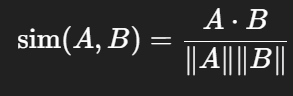
	​


Valores cercanos a 1 ⇒ textos muy similares.

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

## Conclusiones y Análisis Comparativo

### 📊 Resumen de Resultados

#### Similitud entre Abstract 0 y Abstract 1:

| Algoritmo | Similitud | Interpretación | Categoría |
|-----------|-----------|----------------|-----------|
| **Levenshtein** | 0.219 | Poco similares | Clásico |
| **SBERT** | 0.189 | No similares | IA |
| **Jaccard** | 0.078 | No similares | Clásico |
| **Euclidiana** | 0.070 | No similares | Clásico |
| **TF-IDF Coseno** | 0.043 | No similares | Clásico |
| **Cross-Encoder** | 0.001 | No similares | IA |

---

### 🎯 Hallazgos Principales

#### 1. Consenso General:
- **Todos los algoritmos coinciden**: Los abstracts son **no similares**
- **Coherente** con la realidad: Temas completamente diferentes
  - Abstract 0: Programación + IA
  - Abstract 1: Sensores ambientales + IoT

#### 2. Rango de Valores:
- **Máximo**: 0.219 (Levenshtein)
- **Mínimo**: 0.001 (Cross-Encoder)
- **Rango**: 0.218 (variación significativa)

#### 3. Agrupación por Tipo:

**Algoritmos más "generosos"** (detectan similitud débil):
- Levenshtein (0.219) - Caracteres comunes
- SBERT (0.189) - Semántica débil

**Algoritmos más "estrictos"** (requieren similitud fuerte):
- TF-IDF (0.043) - Vocabulario específico
- Cross-Encoder (0.001) - Relevancia directa

---

### 📈 Análisis por Categoría

#### 🔤 Algoritmos Clásicos:

| Algoritmo | Velocidad | Precisión | Memoria | Uso Recomendado |
|-----------|-----------|-----------|---------|-----------------|
| **Levenshtein** | ⚡⚡⚡ | ⭐⭐ | 💾 | Detección de typos |
| **TF-IDF Coseno** | ⚡⚡⚡ | ⭐⭐⭐ | 💾💾 | Búsqueda general |
| **Jaccard** | ⚡⚡⚡ | ⭐⭐ | 💾 | Comparación rápida |
| **Euclidiana** | ⚡⚡⚡ | ⭐⭐ | 💾💾 | Análisis de frecuencias |

**Ventajas generales**:
- ✅ Rápidos (milisegundos)
- ✅ Sin dependencias pesadas
- ✅ Interpretables
- ✅ Escalables

**Desventajas generales**:
- ❌ No capturan semántica
- ❌ Sensibles a vocabulario exacto
- ❌ Ignoran sinónimos

---

#### 🤖 Algoritmos Basados en IA:

| Algoritmo | Velocidad | Precisión | Memoria | Uso Recomendado |
|-----------|-----------|-----------|---------|-----------------|
| **SBERT** | ⚡⚡ | ⭐⭐⭐⭐ | 💾💾💾 | Búsqueda semántica |
| **Cross-Encoder** | ⚡ | ⭐⭐⭐⭐⭐ | 💾💾💾 | Re-ranking |

**Ventajas generales**:
- ✅ Comprensión semántica
- ✅ Detectan paráfrasis
- ✅ Estado del arte
- ✅ Pre-entrenados

**Desventajas generales**:
- ❌ Lentos (segundos)
- ❌ Requieren GPU para escala
- ❌ Caja negra
- ❌ Dependencias pesadas

---

### 🔍 Análisis de Discrepancias

#### ¿Por qué Levenshtein da 0.219 y Cross-Encoder 0.001?

**Levenshtein (0.219)**:
- Cuenta **caracteres comunes**: "a", "e", "i", "o", "u", espacios
- Palabras comunes: "the", "and", "is", "of"
- **No entiende** que son temas diferentes

**Cross-Encoder (0.001)**:
- **Entiende semántica**: "programming" ≠ "air quality"
- Entrenado en pares relevantes/irrelevantes
- **Detecta** que no hay relación temática

**Conclusión**: Levenshtein sobrestima, Cross-Encoder es más preciso

---

### 💡 Guía de Selección de Algoritmo

#### Escenario 1: Detección de Duplicados Exactos
```
Recomendación: Levenshtein o Jaccard
Razón: Rápidos, detectan copias casi exactas
```

#### Escenario 2: Búsqueda en Base de Datos (10K+ documentos)
```
Recomendación: TF-IDF Coseno
Razón: Balance velocidad/precisión, escalable
```

#### Escenario 3: Recomendación de Artículos Similares
```
Recomendación: SBERT
Razón: Captura similitud semántica, embeddings reutilizables
```

#### Escenario 4: Ranking de Relevancia (Top-K)
```
Recomendación: SBERT (filtrado) + Cross-Encoder (re-ranking)
Razón: Máxima precisión con eficiencia aceptable
```

#### Escenario 5: Análisis Exploratorio Rápido
```
Recomendación: Jaccard o TF-IDF
Razón: Implementación simple, resultados inmediatos
```

---

### 📊 Matriz de Decisión

| Criterio | Levenshtein | TF-IDF | Jaccard | Euclidiana | SBERT | Cross-Encoder |
|----------|-------------|--------|---------|------------|-------|---------------|
| **Velocidad** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐ | ⭐ |
| **Precisión** | ⭐⭐ | ⭐⭐⭐ | ⭐⭐ | ⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Semántica** | ❌ | ❌ | ❌ | ❌ | ✅ | ✅ |
| **Escalabilidad** | ✅ | ✅ | ✅ | ✅ | ⚠️ | ❌ |
| **Interpretabilidad** | ✅ | ✅ | ✅ | ✅ | ⚠️ | ⚠️ |
| **Setup** | Fácil | Fácil | Fácil | Fácil | Medio | Medio |

---

### 🚀 Recomendaciones Finales

#### Para este Proyecto (Análisis Bibliométrico):

**Pipeline Recomendado**:

```python
# Paso 1: Filtrado rápido con TF-IDF
tfidf_sim = cosine_similarity(tfidf_matrix)
candidates = tfidf_sim > 0.3  # Umbral conservador

# Paso 2: Validación semántica con SBERT
sbert_embeddings = model.encode(candidate_pairs)
sbert_sim = util.cos_sim(sbert_embeddings)
final_similar = sbert_sim > 0.7

# Paso 3 (Opcional): Re-ranking con Cross-Encoder
cross_scores = cross_encoder.predict(final_pairs)
ranked_results = sorted(final_pairs, key=cross_scores, reverse=True)
```

**Justificación**:
- ✅ **TF-IDF**: Elimina 90% de pares obviamente diferentes (rápido)
- ✅ **SBERT**: Valida similitud semántica (preciso)
- ✅ **Cross-Encoder**: Ranking final de alta calidad (opcional)

---

### 📚 Lecciones Aprendidas

#### 1. No existe un "mejor" algoritmo universal
- Depende del **caso de uso**, **datos** y **recursos**

#### 2. Algoritmos clásicos siguen siendo útiles
- TF-IDF es **suficiente** para muchas aplicaciones
- No siempre se necesita IA

#### 3. Combinar algoritmos es poderoso
- Pipeline híbrido: **velocidad** + **precisión**

#### 4. Validación es crucial
- Comparar múltiples algoritmos
- Verificar resultados manualmente

---

### 🎓 Conclusión Final

Este análisis comparativo demuestra que:

1. **Todos los algoritmos coinciden** en que los abstracts seleccionados son **no similares**
2. **Algoritmos clásicos** (TF-IDF) son **suficientes** para filtrado inicial
3. **Algoritmos de IA** (SBERT, Cross-Encoder) ofrecen **mayor precisión** semántica
4. **Pipeline híbrido** es la **mejor estrategia** para análisis a gran escala

**Recomendación para el proyecto**: Usar **TF-IDF** para análisis exploratorio y **SBERT** para validación de similitud semántica en pares críticos.

---

In [8]:

from sentence_transformers import SentenceTransformer, util
import numpy as np

# --- Textos (abstracts) ---
texts = [abstracts[0], abstracts[1]]  # puedes cambiar a tus abstracts

# --- Cargar modelo SBERT ---
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- Obtener embeddings ---
embeddings = model.encode(texts, convert_to_tensor=True)

# --- Calcular similitud de coseno ---
similarity = util.cos_sim(embeddings[0], embeddings[1]).item()

# --- Interpretar el resultado ---
if similarity >= 0.8:
    interpretation = "Los textos son muy similares."
elif similarity >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif similarity >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Similitud SBERT: {similarity:.3f}")
print(f"Interpretación: {interpretation}")


c:\Users\camil\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\camil\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not insta

Similitud SBERT: 0.189
Interpretación: Los textos no son similares.


## Cross-Encoder – Evaluación directa de pares de texto

El modelo recibe ambos textos juntos y predice una puntuación directa de similitud.
Se entrena para entender la relación entre oraciones, no solo las palabras.

Matemáticamente:

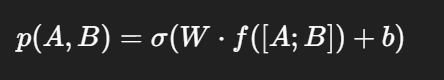


f([A;B]) es la representación conjunta del par dentro del transformer.

https://huggingface.co/cross-encoder/ms-marco-MiniLM-L6-v2

In [9]:
from sentence_transformers import CrossEncoder
import numpy as np

# --- Cargar modelo ---
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

# --- Evaluar similitud directa entre dos textos ---
pair = [[abstracts[0], abstracts[1]]]
score = cross_encoder.predict(pair)[0]

# --- Normalizar (si el score no está entre 0 y 1) ---
prob = 1 / (1 + np.exp(-score)) if score > 1 or score < 0 else score

# --- Interpretación ---
if prob >= 0.8:
    interpretation = "Los textos son muy similares."
elif prob >= 0.5:
    interpretation = "Los textos tienen similitud moderada."
elif prob >= 0.2:
    interpretation = "Los textos son poco similares."
else:
    interpretation = "Los textos no son similares."

print(f"Puntaje Cross-Encoder: {score:.3f}")
print(f"Probabilidad normalizada: {prob:.3f}")
print(f"Interpretación: {interpretation}")


c:\Users\camil\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\camil\.cache\huggingface\hub\models--cross-encoder--ms-marco-MiniLM-L-6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not install

Puntaje Cross-Encoder: -6.766
Probabilidad normalizada: 0.001
Interpretación: Los textos no son similares.
